# Loan Status

Data source: https://www.kaggle.com/zaurbegiev/my-dataset#credit_train.csv

### Dependencies and data

In [1]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras

%matplotlib inline

/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tribui/miniconda3/envs/minds/lib/pyt

In [2]:
# Data
loan_df = pd.read_csv('data/loan_status.csv')
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36423 entries, 0 to 36422
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan_Status                   36423 non-null  object 
 1   Current_Loan_Amount           36423 non-null  int64  
 2   Term                          36423 non-null  object 
 3   Credit_Score                  36423 non-null  float64
 4   Annual_Income                 36423 non-null  float64
 5   Years_in_current_job          36423 non-null  object 
 6   Home_Ownership                36423 non-null  object 
 7   Purpose                       36423 non-null  object 
 8   Monthly_Debt                  36423 non-null  float64
 9   Years_of_Credit_History       36423 non-null  float64
 10  Months_since_last_delinquent  36423 non-null  float64
 11  Number_of_Open_Accounts       36423 non-null  int64  
 12  Number_of_Credit_Problems     36423 non-null  int64  
 13  C

In [3]:
loan_df.head()

,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Annual_Income,Years_in_current_job,Home_Ownership,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,Fully_Paid,99999999,Short_Term,741.0,2231892.0,8_years,Own_Home,Debt_Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
1,Fully_Paid,217646,Short_Term,730.0,1184194.0,<_1_year,Home_Mortgage,Debt_Consolidation,10855.08,19.6,10.0,13,1,122170,272052.0,1.0,0.0
2,Fully_Paid,548746,Short_Term,678.0,2559110.0,2_years,Rent,Debt_Consolidation,18660.28,22.6,33.0,4,0,437171,555038.0,0.0,0.0
3,Fully_Paid,99999999,Short_Term,728.0,714628.0,3_years,Rent,Debt_Consolidation,11851.06,16.0,76.0,16,0,203965,289784.0,0.0,0.0
4,Fully_Paid,99999999,Short_Term,740.0,776188.0,<_1_year,Own_Home,Debt_Consolidation,11578.22,8.5,25.0,6,0,134083,220220.0,0.0,0.0


### Data preprocessing

In [4]:
# Inspect `Current_Loan_Amount` outliers
loan_df.loc[loan_df['Current_Loan_Amount'] > 1e6, 'Current_Loan_Amount'].value_counts()

99999999    4918
Name: Current_Loan_Amount, dtype: int64

In [5]:
# Drop outliers
loan_df = loan_df[loan_df['Current_Loan_Amount'] < 1e6].reset_index()
loan_df.shape

(31505, 18)

In [6]:
# Categorical features
cat_feats = loan_df.dtypes[loan_df.dtypes == object].index.tolist()

# Unique counts
loan_df[cat_feats].nunique()

Loan_Status              2
Term                     2
Years_in_current_job    11
Home_Ownership           4
Purpose                  7
dtype: int64

In [7]:
# Inspect unique values for `Years_in_current_job`
loan_df['Years_in_current_job'].value_counts()

10+_years    11376
2_years       2778
3_years       2594
<_1_year      2331
5_years       2154
1_year        1974
4_years       1965
6_years       1822
7_years       1806
8_years       1437
9_years       1268
Name: Years_in_current_job, dtype: int64

In [8]:
def bucket_years(label):
    
    """ Group a `Years_in_current_job` label into 1 of 3 buckets: 0 - 3, 4 - 9, and 10+ """
    
    if '+' not in label:
        if int(label[0]) < 4:
            return '0-3'
        else:
            return '4-9'
    else:
        return '10+'

# Group `Years_in_current_job` into fewer buckets
loan_df['Years_in_current_job'] = loan_df['Years_in_current_job'].str.replace('<_', '') \
                                                                 .apply(bucket_years)
loan_df['Years_in_current_job'].value_counts()

10+    11376
4-9    10452
0-3     9677
Name: Years_in_current_job, dtype: int64

In [9]:
# One-hot encoding
ohe = OneHotEncoder(sparse=False)
loan_ohe = ohe.fit_transform(loan_df[cat_feats])
loan_ohe = pd.DataFrame(loan_ohe, columns=ohe.get_feature_names(cat_feats))
loan_ohe.head()

,Loan_Status_Fully_Paid,Loan_Status_Not_Paid,Term_Long_Term,Term_Short_Term,Years_in_current_job_0-3,Years_in_current_job_10+,Years_in_current_job_4-9,Home_Ownership_HaveMortgage,Home_Ownership_Home_Mortgage,Home_Ownership_Own_Home,Home_Ownership_Rent,Purpose_Business_Loan,Purpose_Buy_House,Purpose_Buy_a_Car,Purpose_Debt_Consolidation,Purpose_Home_Improvements,Purpose_Medical_Bills,Purpose_Other
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
# Merge data
df = loan_df.drop(columns=cat_feats) \
            .merge(loan_ohe.drop(columns=['Loan_Status_Not_Paid', 'Term_Short_Term']), 
                   left_index=True, right_index=True)
df.head()

,index,Current_Loan_Amount,Credit_Score,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,...,Home_Ownership_Home_Mortgage,Home_Ownership_Own_Home,Home_Ownership_Rent,Purpose_Business_Loan,Purpose_Buy_House,Purpose_Buy_a_Car,Purpose_Debt_Consolidation,Purpose_Home_Improvements,Purpose_Medical_Bills,Purpose_Other
0,1,217646,730.0,1184194.0,10855.08,19.6,10.0,13,1,122170,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,548746,678.0,2559110.0,18660.28,22.6,33.0,4,0,437171,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,5,234124,727.0,693234.0,14211.24,24.7,46.0,10,1,28291,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6,666204,723.0,1821967.0,17612.24,22.0,34.0,15,0,813694,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7,317108,687.0,1133274.0,9632.81,17.4,53.0,4,0,60287,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
# Feature/target split
X = df.drop(columns='Loan_Status_Fully_Paid')
y = df['Loan_Status_Fully_Paid']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23628, 28), (7877, 28), (23628,), (7877,))

In [12]:
# Scale data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.head()

,index,Current_Loan_Amount,Credit_Score,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,...,Home_Ownership_Home_Mortgage,Home_Ownership_Own_Home,Home_Ownership_Rent,Purpose_Business_Loan,Purpose_Buy_House,Purpose_Buy_a_Car,Purpose_Debt_Consolidation,Purpose_Home_Improvements,Purpose_Medical_Bills,Purpose_Other
0,0.544018,-0.992915,-0.230728,-0.339153,0.101740,1.567170,1.797847,-0.503054,-0.349788,-0.577833,...,0.980468,-0.312734,-0.814252,-0.133708,-0.084877,-0.108516,0.542391,-0.262945,-0.112055,-0.358509
1,1.537742,0.075136,-0.245830,0.674808,-0.910346,0.496883,-0.261409,-0.906693,-0.349788,-0.246648,...,0.980468,-0.312734,-0.814252,-0.133708,-0.084877,-0.108516,0.542391,-0.262945,-0.112055,-0.358509
2,-1.336833,-0.743956,-0.236637,-0.385486,-0.100801,-0.317138,-0.124126,0.102404,-0.349788,-0.459013,...,0.980468,-0.312734,-0.814252,-0.133708,-0.084877,-0.108516,0.542391,-0.262945,-0.112055,-0.358509
3,1.204724,1.254585,-0.232697,1.877741,1.511977,-0.166393,0.928383,0.304224,-0.349788,0.203002,...,0.980468,-0.312734,-0.814252,-0.133708,-0.084877,-0.108516,-1.843687,3.803071,-0.112055,-0.358509
4,1.477591,-0.500916,-0.285226,-0.238620,0.638381,-1.131159,0.608054,1.515140,-0.349788,-0.165210,...,-1.019921,-0.312734,1.228121,-0.133708,-0.084877,-0.108516,0.542391,-0.262945,-0.112055,-0.358509


### Neural network

In [13]:
# Sequential NN
nn = keras.models.Sequential(name='27-16-5-1')

# Layers
nn.add(keras.layers.Dense(units=16, activation='relu', input_dim=X_train_scaled.shape[1])) # input + hidden layer 1 w/ 16 neurons
nn.add(keras.layers.Dense(units=5, activation='relu')) # hidden layer 2 w/ 5 neurons
nn.add(keras.layers.Dense(units=1, activation='sigmoid')) # output layer

nn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "27-16-5-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 555
Trainable params: 555
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Checkpoint path
os.makedirs('checkpoints/', exist_ok=True) # create direcory for checkpoints
checkpoint_path = 'checkpoints/weights.{epoch:02d}.hdf5'

# Checkpoint callback
cp_freq = X_train_scaled.shape[0] * 5 # save cp every 5 epochs
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                              save_weights_only=True, 
                                              save_freq=cp_freq, 
                                              verbose=1)

In [15]:
# Compile model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
nn_trained = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[cp_callback])

# Evaluate model
print('\nTest set performance:')
nn.evaluate(X_test_scaled, y_test, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
23628/23628 [==============================] - 1s 45us/sample - loss: 0.4943 - acc: 0.8021
Epoch 2/50
23628/23628 [==============================] - 1s 45us/sample - loss: 0.4468 - acc: 0.82360s - loss: 0.4455 - acc:
Epoch 3/50
23628/23628 [==============================] - 1s 42us/sample - loss: 0.4432 - acc: 0.8242
Epoch 4/50
23628/23628 [==============================] - 1s 42us/sample - loss: 0.4413 - acc: 0.8242
Epoch 5/50
23552/23628 [============================>.] - ETA: 0s - loss: 0.4390 - acc: 0.824 - ETA: 0s - loss: 0.4397 - acc: 0.8242
Epoch 00005: saving model to checkpoints/weights.05.hdf5
23628/23628 [==============================] - 1s 50us/sample - loss: 0.4400 - acc: 0.8240
Epoch 6/50
23628/23628 [==============================] - 1s 49us/sample - loss: 0.4384 - acc: 0.8240
Epoch 7/50
23628/23628 [==============================] - 1s 62us/sample - loss: 0.4375 - a

[0.4375183773219351, 0.82658374]

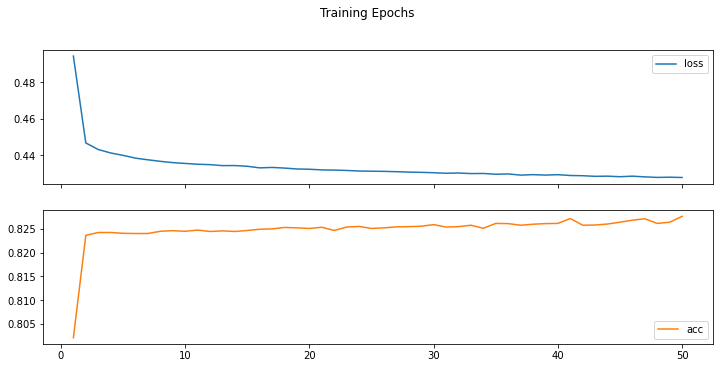

In [16]:
# Plot training loss and accuracy
nn_history = pd.DataFrame(nn_trained.history, index=range(1, len(nn_trained.history['loss']) + 1))
nn_history.plot(subplots=True, figsize=(12, 6), title='Training Epochs')
plt.xticks(rotation=0, ha='center')
plt.show()

### Neural network using checkpoint weights

In [21]:
# Sequential NN
cp = keras.models.Sequential(name='checkpoint')

# Layers
cp.add(keras.layers.Dense(units=16, activation='relu', input_dim=X_train_scaled.shape[1]))
cp.add(keras.layers.Dense(units=5, activation='relu'))
cp.add(keras.layers.Dense(units=1, activation='sigmoid'))

# Compile model
cp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cp.summary()

Model: "checkpoint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 85        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 555
Trainable params: 555
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Restore model weights from a saved checkpoint
cp.load_weights('checkpoints/weights.40.hdf5')

# Evaluate model
cp.evaluate(X_test_scaled, y_test, verbose=2)

7877/7877 - 0s - loss: 0.4375 - acc: 0.8259


[0.4374994982676683, 0.82594895]

### Compare performance to other classifiers

In [17]:
# Logistic regression
lr = LogisticRegression(random_state=27)
lr.fit(X_train_scaled, y_train)
print('Train set accuracy:', lr.score(X_train_scaled, y_train))
print('Test set accuracy:', lr.score(X_test_scaled, y_test))

Train set accuracy: 0.824064669036736
Test set accuracy: 0.8298844737844357


In [18]:
# Random forest
rf = RandomForestClassifier(random_state=27)
rf.fit(X_train_scaled, y_train)
print('Train set accuracy:', rf.score(X_train_scaled, y_train))
print('Test set accuracy:', rf.score(X_test_scaled, y_test))

Train set accuracy: 1.0
Test set accuracy: 0.8310270407515552


### Save model

In [24]:
# Save NN model
os.makedirs('models/', exist_ok=True) # create directory for models
model_path = 'models/loan_50ep.h5'
nn.save(model_path)

# Load model
nn_loaded = keras.models.load_model(model_path)
nn_loaded.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "27-16-5-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 555
Trainable params: 555
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Evaluate model
nn_loaded.evaluate(X_test_scaled, y_test, verbose=2)

7877/7877 - 0s - loss: 0.4375 - acc: 0.8266


[0.4375183773219351, 0.82658374]